### Libraries

In [1]:

import os
import ot
import sys
import time
import torch
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import json
from itertools import zip_longest
import warnings

from tqdm import tqdm
from sklearn.svm import SVC
from torchvision.utils import make_grid
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,accuracy_score ,precision_score, recall_score
from sklearn.metrics import f1_score,confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


from IPython.display import HTML
from matplotlib.animation import FuncAnimation

CONSTANTS

In [2]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18 
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

n_datasets = 4 
n_classes = 7
n_dim = 256
device = 'cpu'
base_path = "assets"

### Read data

In [3]:
def extract_pressure_matrices(json_data):
    pressure_matrices = []
    for entry in json_data['pressureData']:
        pressure_matrix = entry["pressureMatrix"]
        pressure_matrices.append({"pressureMatrix": pressure_matrix})
    return pressure_matrices

def extract_features_from_pressure_matrices(pressure_matrices):
    
    flattened_data = [np.array(item["pressureMatrix"]).reshape(1,-1) for item in pressure_matrices]
    #print(flattened_data[0].shape)
    return np.concatenate(flattened_data, axis=0)

Let's look at the first four subjects first. And say that the fourth has no label, to be our target domain

In [4]:
def process_subjects(data_type):
    true_features = []
    true_labels = []
    Xs, Ys = [], []
    subjects_to_iterate = [1, 2, 3,4,5]

    for subject_id in subjects_to_iterate:
        subject_data = []
        subject_labels = []
        subject_path = os.path.join(base_path, f"Subject_{subject_id}", data_type)

        if data_type == "Continuous_data":
            json_files = [f for f in os.listdir(subject_path) if f.endswith('.json')]
        elif data_type == "Posture_data":
            json_files = [f"Posture_{i}.json" for i in range(1, 8)]
        else:
            raise ValueError("Invalid data type. Choose either 'Continuous_data' or 'Posture_data'.")

        # Loop over each file for the current subject
        for file_name in json_files:
            file_path = os.path.join(subject_path, file_name)

            with open(file_path, 'r') as file:
                json_data = json.load(file)
                pressure_matrices = extract_pressure_matrices(json_data)
                features = extract_features_from_pressure_matrices(pressure_matrices)

                subject_data.append(features)

                if data_type == "Posture_data":
                    posture_label = int(file_name.split("_")[1].split(".")[0])
                    labels = np.full((features.shape[0],), posture_label) # create label vector
                    subject_labels.extend(labels)

        # Create DataFrame for the current subject
        df_features = pd.DataFrame(np.concatenate(subject_data, axis=0)) # X
        X = df_features.values
        true_features.append(X)
        # Converts the generated features and labels into PyTorch tensors
        Xs.append(torch.from_numpy(X).float())
        
        if data_type == "Posture_data":
            df_labels = pd.DataFrame(subject_labels, columns=["Posture"]) # y
            y = np.array(subject_labels)
            # Adjusting the labels to start from 0
            y_adjusted = y - 1
            true_labels.append(y_adjusted)
            Ys.append(torch.nn.functional.one_hot(torch.from_numpy(y_adjusted).long(), num_classes=n_classes).float())

    # Process subject 6 separately : target domain
    subject_id = 6
    subject_data = []
    subject_labels = []
    subject_path = os.path.join(base_path, f"Subject_{subject_id}", data_type)

    if data_type == "Continuous_data":
        json_files = [f for f in os.listdir(subject_path) if f.endswith('.json')]
    elif data_type == "Posture_data":
        json_files = [f"Posture_{i}.json" for i in range(1, 8)]

    for file_name in json_files:
        file_path = os.path.join(subject_path, file_name)

        with open(file_path, 'r') as file:
            json_data = json.load(file)
            pressure_matrices = extract_pressure_matrices(json_data)
            features = extract_features_from_pressure_matrices(pressure_matrices)

            subject_data.append(features)

            if data_type == "Posture_data":
                posture_label = int(file_name.split("_")[1].split(".")[0])
                labels = np.full((features.shape[0],), posture_label)
                subject_labels.extend(labels)

    df_features = pd.DataFrame(np.concatenate(subject_data, axis=0))
    X = df_features.values
    true_features.append(X)
    Xt_tr = torch.from_numpy(X).float()

    if data_type == "Posture_data":
        y = np.array(subject_labels)
        y_adjusted = y - 1
        Yt_tr = torch.nn.functional.one_hot(torch.from_numpy(y_adjusted).long(), num_classes=n_classes).float()
        true_labels.append(y_adjusted)
        return true_features, true_labels, Xs, Ys, Xt_tr, Yt_tr, pressure_matrices,features

    return true_features, Xs, Xt_tr, pressure_matrices,features

posture_true_features, posture_true_labels, Xs_posture, Ys_posture, Xt_tr_posture, Yt_tr_posture,pressure_matrices_posture_ex,features_posture_ex = process_subjects("Posture_data")
posture_datasets = [(Xsk, Ysk) for Xsk, Ysk in zip(Xs_posture, Ys_posture)] + [(Xt_tr_posture, None)]
continuous_true_features, Xs_continuous, Xt_tr_continuous, pressure_matrices_continuous_ex,features_continuous_ex = process_subjects("Continuous_data")

# Data Analysis

We have too little posture data to make a meaningful prediction, we need to collect more data

In [5]:
print(posture_true_features[0].shape) #Features of subject 1
print(posture_true_features[1].shape) #Features of subject 2
print(posture_true_features[2].shape) #Features of subject 3
print(posture_true_features[3].shape) #Features of subject 4
print(posture_true_features[4].shape) #Features of subject 5
print(posture_true_features[5].shape) #Features of subject 6

(349, 256)
(236, 256)
(160, 256)
(238, 256)
(604, 256)
(13228, 256)


In [6]:
all_data_posture = pd.concat([pd.DataFrame(np.concatenate(posture_true_features, axis=0)), pd.DataFrame(np.concatenate(posture_true_labels, axis=0))], axis=1)

all_data_posture.iloc[:,-1].value_counts()

0
2    2381
0    2369
4    2331
6    2148
3    1896
1    1894
5    1796
Name: count, dtype: int64

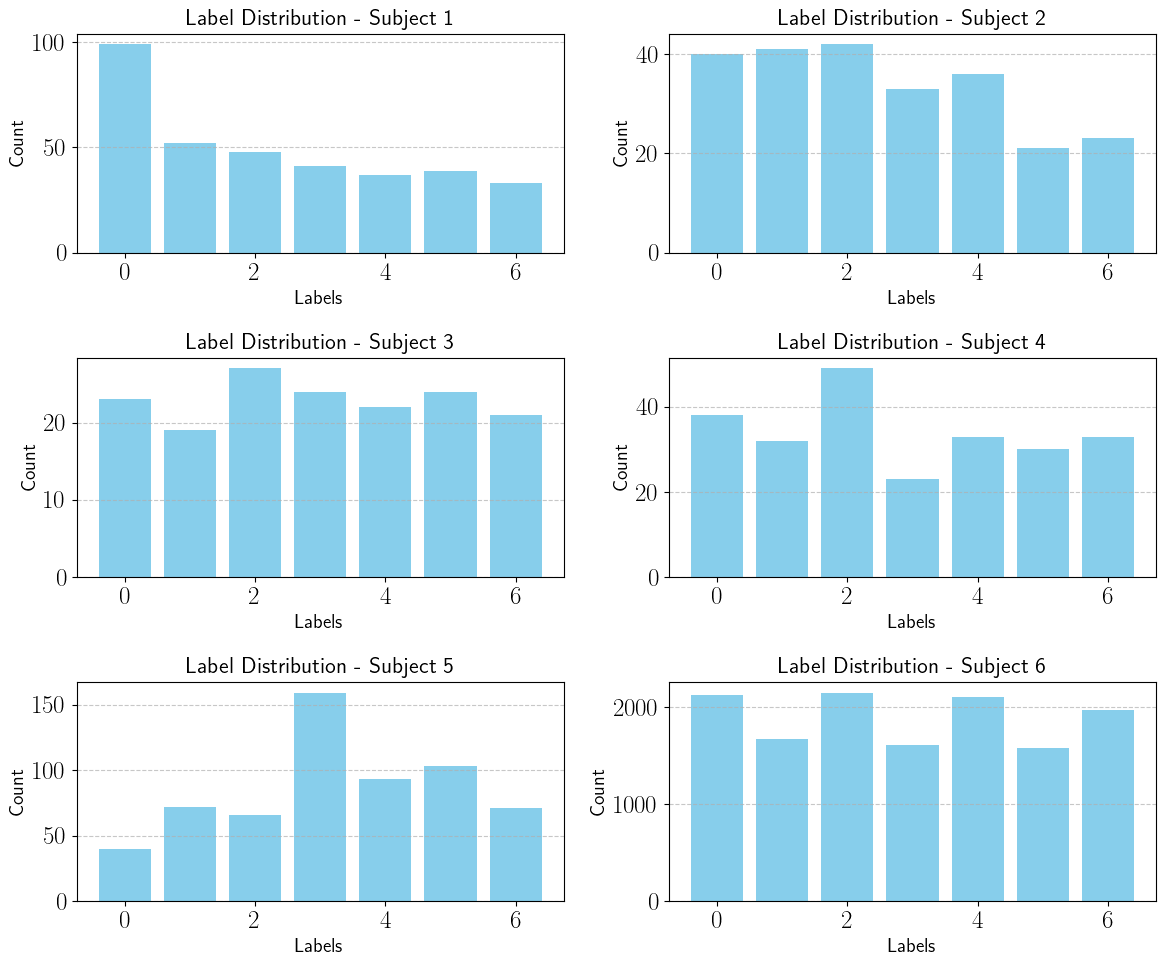

In [11]:
def plot_label_counts(labels, counts, subject_number, ax):
    ax.bar(labels, counts, color='skyblue')
    ax.set_title(f'Label Distribution - Subject {subject_number}', fontsize=16)
    ax.set_xlabel('Labels', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig, axs = plt.subplots(3, 2, figsize=(12, 10))

subject_1_labels, subject_1_counts = np.unique(posture_true_labels[0], return_counts=True)
subject_2_labels, subject_2_counts = np.unique(posture_true_labels[1], return_counts=True)
subject_3_labels, subject_3_counts = np.unique(posture_true_labels[2], return_counts=True)
subject_4_labels, subject_4_counts = np.unique(posture_true_labels[3], return_counts=True)
subject_5_labels, subject_5_counts = np.unique(posture_true_labels[4], return_counts=True)

subject_6_labels, subject_6_counts = np.unique(posture_true_labels[-1], return_counts=True)

subject_labels = [subject_1_labels, subject_2_labels, subject_3_labels, subject_4_labels, subject_5_labels, subject_6_labels]
subject_counts = [subject_1_counts, subject_2_counts, subject_3_counts, subject_4_counts, subject_5_counts, subject_6_counts]

for i in range(6):
    row = i // 2
    col = i % 2
    plot_label_counts(subject_labels[i], subject_counts[i], i+1, axs[row, col])

plt.tight_layout()
plt.show()

Each value corresponds to a pressure intensity, and each line corresponds to a different time instant, the data is collected approximately every 0.0588088 seconds.

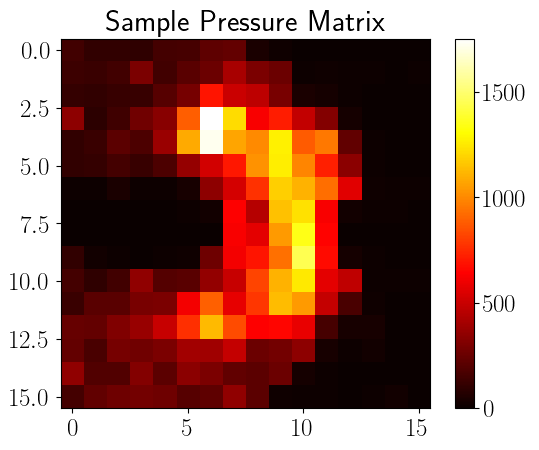

In [9]:
# Analysis of a Sample Pressure Matrix
sample_pressure_matrix = np.array(pressure_matrices_posture_ex[0]["pressureMatrix"])
plt.imshow(sample_pressure_matrix, cmap='hot', interpolation='nearest')
plt.title('Sample Pressure Matrix')
plt.colorbar()
plt.show()

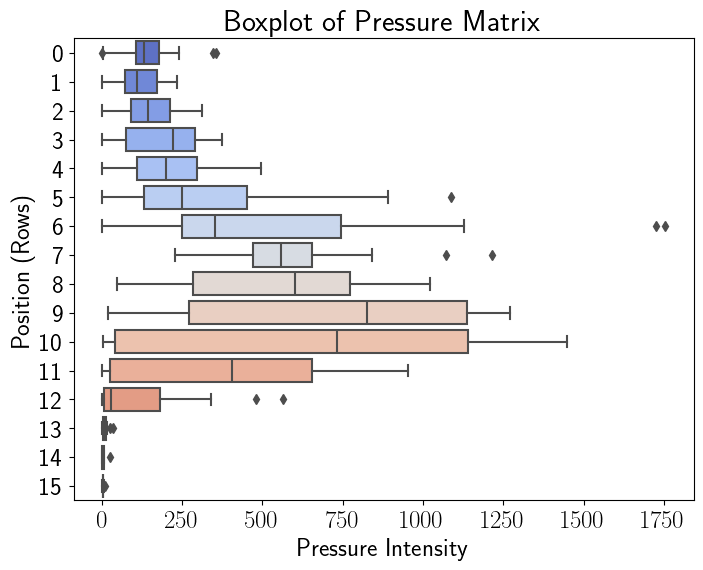

In [10]:
# Plotting a boxplot of the pressure matrix
plt.figure(figsize=(8, 6))
sns.boxplot(data=sample_pressure_matrix, orient='h', palette='coolwarm')
plt.title('Boxplot of Pressure Matrix')
plt.xlabel('Pressure Intensity')
plt.ylabel('Position (Rows)')
plt.show()

Merge Features

In [12]:
posture_with_labels = []
data_continuous_concat = []
for posture, labels, continuous in zip(posture_true_features, posture_true_labels, continuous_true_features):
    posture_with_labels.append(pd.concat([pd.DataFrame(posture), pd.DataFrame(labels)], axis=1).values)
    continuous_labels_sample = -1 * np.ones((continuous.shape[0], 1))
    data_continuous_concat.append(pd.concat([pd.DataFrame(continuous), pd.DataFrame(continuous_labels_sample)], axis=1).values)
    
features_merged = [np.concatenate((posture, continuous), axis=0) for posture, continuous in zip(posture_true_features, continuous_true_features)]
features_merged_with_labels = [np.concatenate((posture, continuous), axis=0) for posture, continuous in zip(posture_with_labels, data_continuous_concat)]
    

## Visualization with PCA - Posture data

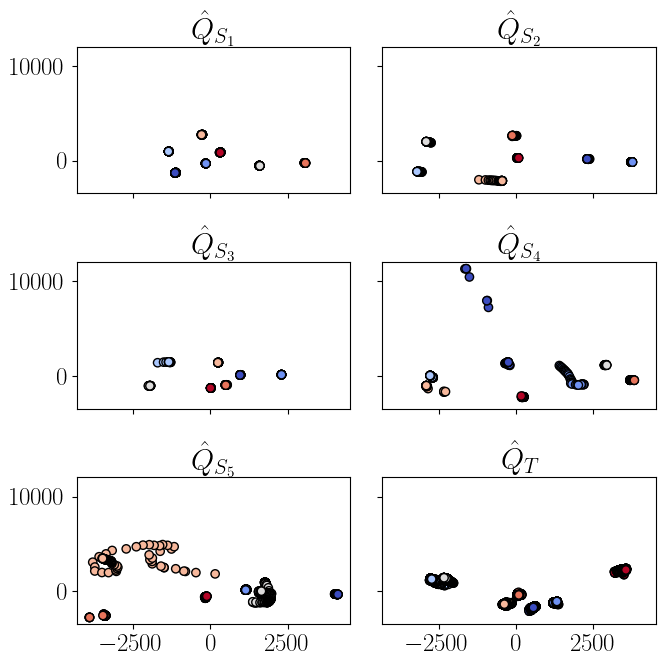

In [17]:
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(posture_true_features[:-1], posture_true_labels[:-1], axes.flatten()[:-1])):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Xi)
    #ax.scatter(x = pca_result[:, 0], y = pca_result[:, 1], c=Yi[:,0], cmap='coolwarm', edgecolor='k')
    ax.scatter(x = pca_result[:, 0], y = pca_result[:, 1], c=Yi, cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

# Plot the last dataset separately
ax = axes.flatten()[-1]
pca_last = pca.fit_transform(posture_true_features[-1]) 
#ax.scatter(pca_last[:, 0], pca_last[:, 1], c=true_labels[-1][:,0], cmap='coolwarm', edgecolor='k')
ax.scatter(pca_last[:, 0], pca_last[:, 1], c=posture_true_labels[-1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

plt.tight_layout()
plt.show()

Visualization with t-SNE

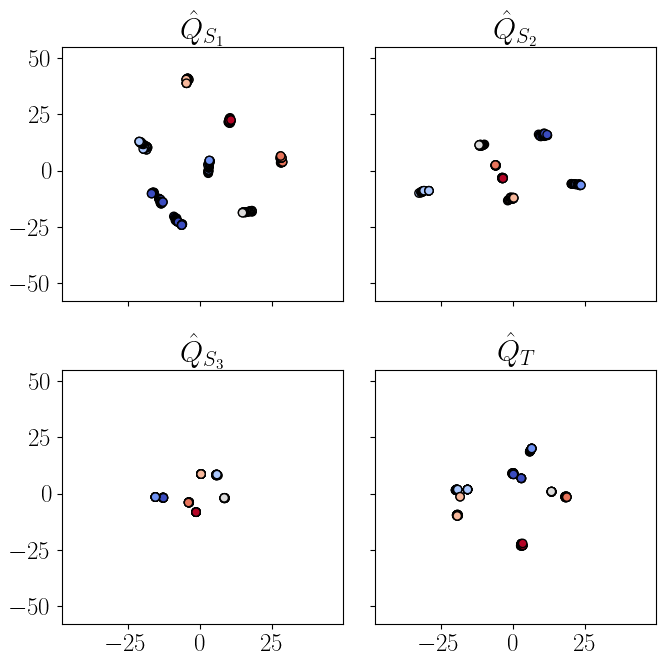

In [62]:
# Apply t-SNE
tsne_all = TSNE(n_components=2)
tsne_result_all = tsne_all.fit_transform(all_data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(Xi)
    ax.scatter(x = tsne_result[::2, 0], y = tsne_result[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
    ax.set_xlim([np.min(tsne_result_all[:, 0]) - 5, np.max(tsne_result_all[:, 0]) + 5])
    ax.set_ylim([np.min(tsne_result_all[:, 1]) - 5, np.max(tsne_result_all[:, 1]) + 5])

# Plot the last dataset separately
ax = axes.flatten()[-1]
tsne_last = tsne.fit_transform(true_features[-1]) 
ax.scatter(tsne_last[::2, 0], tsne_last[::2, 1], c=true_labels[-1][::2], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

plt.tight_layout()
plt.show()

Visualization with UMAP

c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


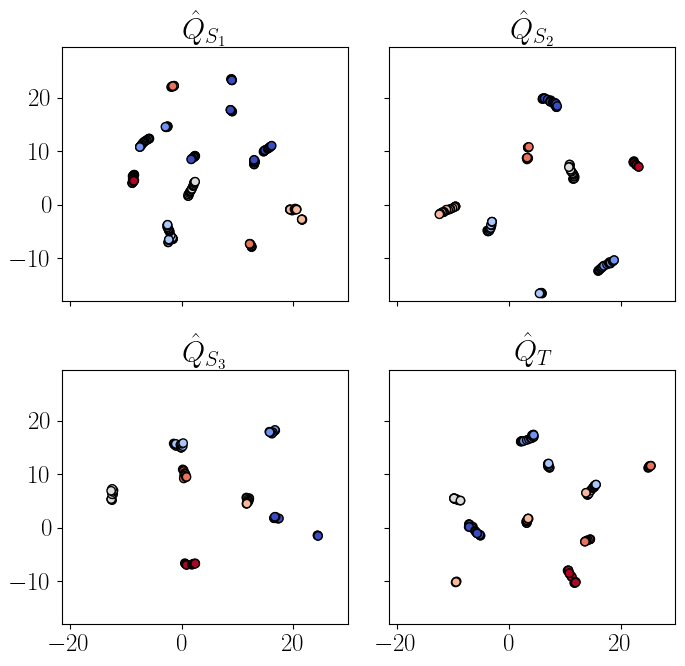

In [63]:
# Apply UMAP to set the limits to the plot after
umap_all = umap.UMAP(n_components=2)
umap_result_all = umap_all.fit_transform(all_data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    umap_model = umap.UMAP(n_components=2)
    umap_result = umap_model.fit_transform(Xi)
    ax.scatter(x = umap_result[::2, 0], y = umap_result[::2, 1], c=Yi[::2], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
    ax.set_xlim([np.min(umap_result_all[:, 0]) - 5, np.max(umap_result_all[:, 0]) + 5])
    ax.set_ylim([np.min(umap_result_all[:, 1]) - 5, np.max(umap_result_all[:, 1]) + 5])

# Plot the last dataset separately
ax = axes.flatten()[-1]
umap_last = umap_model.fit_transform(true_features[-1]) 
ax.scatter(umap_last[::2, 0], umap_last[::2, 1], c=true_labels[-1][::2], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

plt.tight_layout()
plt.show()

## Wasserstein Barycenters


In [64]:
def wasserstein_barycenter(XP, # atom
                           YP=None, # atom label
                           XB=None, # initial guess for the barycenter
                           YB=None, #labels of the initial guess for the barycenter
                           weights=None,
                           n_samples=None, #number of atoms
                           n_iter_max=10,
                           tol=1e-9, #Tolerance for convergence.
                           verbose=False,
                           inner_verbose=False,
                           propagate_labels=False,
                           penalize_labels=False):
    if n_samples is None and XB is None:
        # If number of points is not provided,
        # assume that the support of the barycenter has sum(nsi) where si is the i-th source domain.
        n_samples = int(np.sum([len(XPk) for XPk in XP]))
    
    if YP is None:
        if propagate_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                             " for 'propagate_labels' = True"))
        if penalize_labels:
            raise ValueError(("Expected labels to be given in 'y'"
                              " for 'penalize_labels' = True"))
    else:
        n_classes = YP[0].shape[1]
    #Initialization of data types, device, and weights.
    dtype = XP[0].dtype
    device = XP[0].device

    if weights is None:
        weights = (torch.ones(len(XP)) / len(XP)).to(dtype).to(device)

    it = 0
    comp_start = time.time()

    # Initializes Features
    if XB is None:
        XB = torch.randn(n_samples, XP[0].shape[1])

    # Initializes Labels
    if YB is None:
        yB = torch.from_numpy(
            np.random.randint(low=0,
                              high=n_classes,
                              size=n_samples)).long()
        YB = torch.nn.functional.one_hot(
            yB, num_classes=n_classes).float()

    # Displacement of points in the support
    delta = tol + 1
    last_loss = np.inf
    # Create uniform weights
    u_P = [torch.ones(len(XPk), device=device) / len(XPk) for XPk in XP]
    u_B = torch.ones(len(XB), device=device) / len(XB)

    #Sinkhorn algorithm iterates until convergence or reaching the maximum number of iterations.
    while (delta > tol and it < n_iter_max):
        # NOTE: Here we solve the barycenter problem without calculating
        # gradients at each iteration, as per the envelope theorem, we
        # only need to compute gradients at optimality.
        with torch.no_grad():
            C, ot_plans = [], []

            for k in range(len(XP)):
                C_k = torch.cdist(XP[k], XB, p=2) ** 2
                if penalize_labels:
                    C_k += C_k.detach().max() * torch.cdist(YP[k], YB, p=2) ** 2
                plan_k = ot.emd(u_P[k], u_B, C_k)
                C.append(C_k)
                ot_plans.append(plan_k.to(dtype))
            XB = sum([
                w_k * n_samples * torch.mm(plan_k.T, XP_k)
                for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
            ])
            if propagate_labels:
                YB = sum([
                    w_k * n_samples * torch.mm(plan_k.T, YP_k)
                    for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
                ])
            loss = sum([
                torch.sum(C_k * plan_k) for C_k, plan_k in zip(C, ot_plans)
            ])
            delta = torch.norm(loss - last_loss) / n_samples
            last_loss = loss

            it += 1
    # Re-evaluate the support at optimality for calculating the gradients
    # NOTE: now we define the support while holding its gradients w.r.t. the
    # weight vector and eventually the support.
    XB = sum([
        w_k * n_samples * torch.mm(plan_k.T, XP_k)
        for w_k, plan_k, XP_k in zip(weights, ot_plans, XP)
    ])
    if propagate_labels:
        YB = sum([
            w_k * n_samples * torch.mm(plan_k.T, YP_k)
            for w_k, plan_k, YP_k in zip(weights, ot_plans, YP)
        ])
        return XB, YB
    return XB

## Dictionary Learning


### Hyper Parameters

In [65]:
lr = 1e-1 #Learning rate for optimization.
n_iter_max = 40 #Maximum number of iterations for training.
n_samples = 1022
#n_samples = min(len(X) for X in true_features) 
batch_size = 128
n_components = 3 
batches_per_it = n_samples // batch_size
spc = n_samples // n_classes
spc_batches = batch_size // n_classes

### Optimization variables definition

In [66]:
XP = torch.nn.ParameterList([  #. Each component is a 256D tensor.
    torch.nn.parameter.Parameter(data=torch.randn(n_samples, 256), requires_grad=True)
    for _ in range(n_components)
])

YP_init = []
for _ in range(n_components):
    ypk = torch.cat(
        [torch.tensor([c] * spc)
         for c in range(n_classes)]
    ).long()
    YPk = torch.nn.functional.one_hot(ypk,
                                      num_classes=n_classes)
    YP_init.append(YPk)
    
YP = torch.nn.ParameterList([       
    torch.nn.parameter.Parameter(data=yp.float(),
                                 requires_grad=True)
    for yp in YP_init]
)

A0 = torch.ones(n_datasets, n_components) / n_components

A = torch.nn.parameter.Parameter(data=A0, requires_grad=True) # barycentric weight matrice

optimizer = torch.optim.Adam([*XP, *YP, A], lr=lr)

### Loss Definition

In [67]:
class JointWassersteinDistance(torch.nn.Module):
    def __init__(self):
        super(JointWassersteinDistance, self).__init__()

    def forward(self, XQ, YQ, XP, YP, index=None):
        a = torch.ones(XP.shape[0], device=XP.device) / XP.shape[0]
        b = torch.ones(XQ.shape[0], device=XQ.device) / XQ.shape[0]
        CX = torch.cdist(XP, XQ, p=2) ** 2

        if YP is not None and YQ is not None:
            CY = torch.cdist(YP, YQ, p=2) ** 2
        else:
            CY = torch.zeros_like(CX)

        label_weight = CX.detach().max()

        C = CX + label_weight * CY
        with torch.no_grad():
            # NOTE: We DO NOT backpropagate through
            #       the OT plan.
            plan = ot.emd(a, b, C) #it computes the optimal transport plan for the given cost matrix C.
        return torch.sum(C * plan)

In [68]:
criterion = JointWassersteinDistance()

### Learning Loop

In [69]:
fit_history = {
    'weights': [],
    'loss': [],
    'atoms_features': [],
    'atoms_labels': []
}

for it in range(n_iter_max):
    pbar = tqdm(range(batches_per_it))
    avg_it_loss = 0.0
    for _ in pbar:
        optimizer.zero_grad()
        
        loss = 0.0
        for l, ((XQl, YQl), al) in enumerate(zip(posture_datasets, A)):
            # Samples a minibatch from XQl
            if YQl is None:
                indices = np.random.choice(np.arange(len(XQl)), size=batch_size)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = None
            else:
                yQl = YQl.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yQl == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                minibatch_XQl = XQl[indices]
                minibatch_YQl = YQl[indices]
                
            # Samples a minibatch from each XP
            minibatch_XP = []
            minibatch_YP = []
            for XPk, YPk in zip(XP, YP):
                yPk = YPk.argmax(dim=1)
                indices = []
                for c in range(n_classes):
                    ind = np.random.choice(np.where(yPk == c)[0], size=spc_batches)
                    indices.append(ind)
                indices = np.concatenate(indices)
                
                minibatch_XP.append(XPk[indices])
                minibatch_YP.append(YPk[indices].softmax(dim=1))
                
            # Calculates a Wasserstein Barycenter
            minibatch_XBl, minibatch_YBl = wasserstein_barycenter(
                XP=minibatch_XP,#atoms en entré
                YP=minibatch_YP,
                XB=None,
                YB=None,
                weights=al,
                n_samples=batch_size,
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=True,
                penalize_labels=True)
            
            #erreur d'approximation
            loss_l = criterion(minibatch_XQl, 
                               minibatch_YQl,
                               minibatch_XBl,
                               minibatch_YBl)
            loss += loss_l
        # Backprop
        loss.backward()
        
        # Optimization Step
        optimizer.step() #mettre a jour les atoms et les poids pour reduire l'approximation
        
        # project weights back into the simplex
        with torch.no_grad():
            A.data = ot.utils.proj_simplex(A.data.T).T
        
        # Save it for logging
        avg_it_loss += loss.item() / batches_per_it
    # Save vars for plotting
    fit_history['weights'].append(A.data.detach().clone())
    fit_history['loss'].append(avg_it_loss)
    fit_history['atoms_features'].append([XPk.data.detach().clone() for XPk in XP])
    fit_history['atoms_labels'].append([YPk.data.detach().clone() for YPk in YP])
    print(f'It {it} our of {n_iter_max}. Loss: {avg_it_loss}')

100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


It 0 our of 40. Loss: 263495830.85714287


100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


It 1 our of 40. Loss: 235843426.2857143


100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


It 2 our of 40. Loss: 213249136.00000003


100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


It 3 our of 40. Loss: 198515954.28571427


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


It 4 our of 40. Loss: 191601915.4285714


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


It 5 our of 40. Loss: 187578489.14285716


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


It 6 our of 40. Loss: 186081778.2857143


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


It 7 our of 40. Loss: 185966118.85714284


100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


It 8 our of 40. Loss: 182952192.0


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


It 9 our of 40. Loss: 183551398.85714284


100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


It 10 our of 40. Loss: 186116587.4285714


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


It 11 our of 40. Loss: 182374361.14285713


100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


It 12 our of 40. Loss: 184247444.57142857


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


It 13 our of 40. Loss: 183187403.42857143


100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


It 14 our of 40. Loss: 183037373.71428573


100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


It 15 our of 40. Loss: 182931894.85714287


100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


It 16 our of 40. Loss: 181688758.85714284


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


It 17 our of 40. Loss: 181106276.57142857


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


It 18 our of 40. Loss: 183745766.85714287


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


It 19 our of 40. Loss: 181691136.0


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


It 20 our of 40. Loss: 181743876.57142857


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


It 21 our of 40. Loss: 181612418.2857143


100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


It 22 our of 40. Loss: 180514466.2857143


100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


It 23 our of 40. Loss: 180058153.14285716


100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


It 24 our of 40. Loss: 180309769.14285713


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


It 25 our of 40. Loss: 180065664.0


100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


It 26 our of 40. Loss: 180797568.0


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


It 27 our of 40. Loss: 180765067.42857143


100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


It 28 our of 40. Loss: 179635058.28571427


100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


It 29 our of 40. Loss: 178707019.42857143


100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


It 30 our of 40. Loss: 180452914.2857143


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


It 31 our of 40. Loss: 180860020.57142854


100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


It 32 our of 40. Loss: 180043700.57142857


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


It 33 our of 40. Loss: 177764713.14285713


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


It 34 our of 40. Loss: 178421721.14285716


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


It 35 our of 40. Loss: 179431627.42857143


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


It 36 our of 40. Loss: 179231222.85714287


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


It 37 our of 40. Loss: 176878884.57142857


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


It 38 our of 40. Loss: 177896932.57142857


100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

It 39 our of 40. Loss: 177525780.57142857


Now, let us analyze how the different $\alpha_{\ell}$ evolve throughout training,

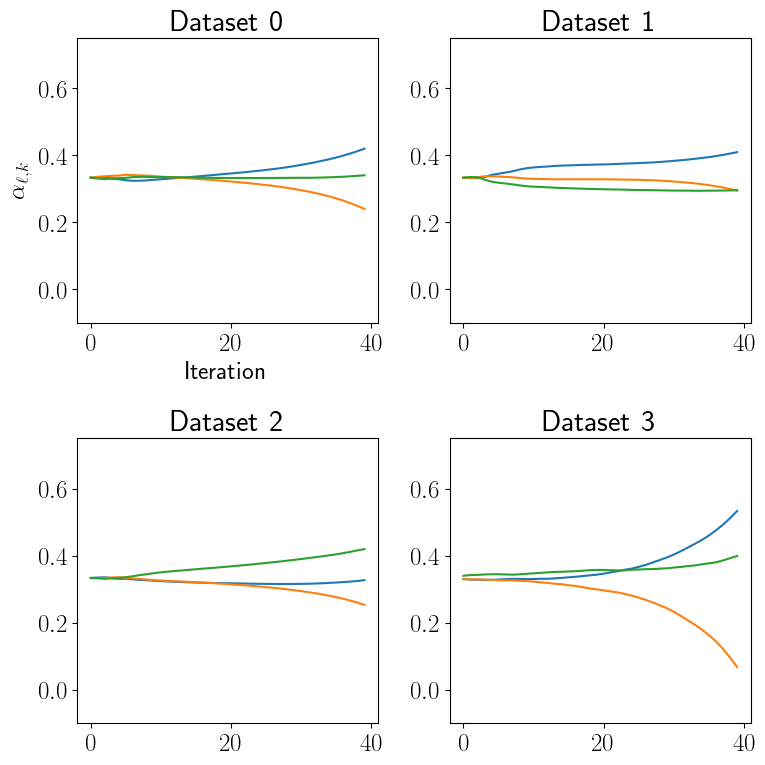

In [70]:
whist = torch.stack(fit_history['weights'])

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    for k in range(n_components):
        ax.plot(whist[:, i, k], label='Atom {}'.format(k + 1))
    ax.set_title(f'Dataset {i}')
    #ax.set_ylim([0.31, 0.36])
    ax.set_ylim([-0.1, 0.75])
axes[0, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[0, 0].set_xlabel('Iteration')
plt.tight_layout()

Likewise, we are interested in how $\mathbf{X}^{(P_{k})}$ and $\mathbf{Y}^{(P_{k})}$ change throughout the iterations,

In [71]:
XPtrajectory = torch.stack([torch.stack(XPit) for XPit in fit_history['atoms_features']])
YPtrajectory = torch.stack([torch.stack(YPit) for YPit in fit_history['atoms_labels']])

We need to find out what makes the dimensions 1022 and 1024 different. These dimensions must be equal:

In [72]:
print(XPtrajectory.shape)
print(YPtrajectory.shape)

torch.Size([40, 3, 1022, 256])
torch.Size([40, 3, 1022, 7])


In [73]:
XP = [XPk.detach() for XPk in XP]
YP = [YPk.detach() for YPk in YP]
A = A.detach()

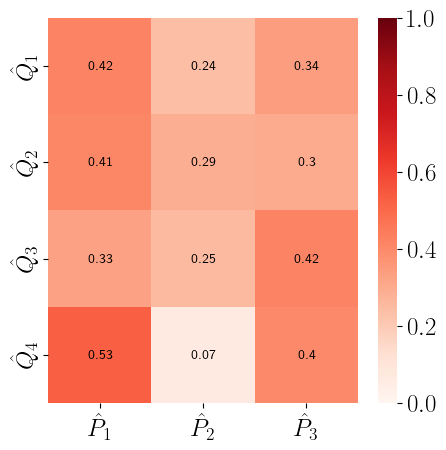

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.heatmap(np.round(A, 2), cmap='Reds', ax=ax, vmin=0, vmax=1, cbar=True)
_ = ax.set_yticks([i + .5 for i in range(len(true_features))],
                  [r"$\hat{Q}_{" + str(i + 1) + "}$" for i in range(len(true_features))])
_ = ax.set_xticks([i + .5 for i in range(len(XP))],
                  [r"$\hat{P}_{" + str(i + 1) + "}$" for i in range(len(XP))])

for i in range(len(true_features)):
    for j in range(len(XP)):
        ax.text(j + 0.5, i + 0.5, str(np.round(A[i, j].item(), 2)), ha='center', va='center', fontsize=10)

we can fit a classifier (in this case, a SVM) on each atom, that is, we find,
$$\hat{h}_{k} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{P_{k}}(h)$$

In [75]:
classifiers = []
for X_atom, Y_atom in zip(XP, YP):
    y_atom = Y_atom.argmax(axis=1)
    
    classifiers.append(SVC(kernel='rbf', probability=True).fit(X_atom, y_atom))

# Dadil - R : reconstruct the target domain using a Wasserstein barycenter

Now, let us reconstruct the target domain using a Wasserstein barycenter. This corresponds to iterating,

$$\hat{\mathbf{x}}^{(B_{T})}_{i} = \sum_{k}\alpha_{T,k}T_{\pi^{(k)}}(\mathbf{x}_{i}^{(B_{T})}) = n\sum_{k}\alpha_{T,k}\sum_{j=1}^{n}\pi_{i,j}^{(k)}\mathbf{x}_{j}^{(P_{k})}$$

$$\hat{\mathbf{y}}^{(B_{T})}_{i} = \sum_{k}\alpha_{T,k}T_{\pi^{(k)}}(\mathbf{y}_{i}^{(B_{T})}) = n\sum_{k}\alpha_{T,k}\sum_{j=1}^{n}\pi_{i,j}^{(k)}\mathbf{y}_{j}^{(P_{k})}$$

Until convergence (see Algorithm 1 in the paper).

In [77]:
Xr, Yr = wasserstein_barycenter(
                XP=XP,
                YP=[YPk.softmax(dim=1) for YPk in YP],
                XB=None,
                YB=None,
                weights=A[-1, :],
                n_samples=len(Xt_tr),
                n_iter_max=10,
                tol=1e-9,
                verbose=False,
                inner_verbose=False,
                propagate_labels=True,
                penalize_labels=True)

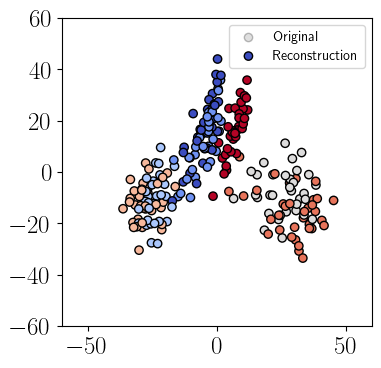

In [78]:
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

X = pca.fit_transform(true_features[-1])
ax.scatter(x=X[:, 0], y=X[:, 1], color='gray', edgecolor='k', alpha=0.25, label='Original')

X, Y = pca.fit_transform(Xr), Yr
y = Y.argmax(axis=1)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', label='Reconstruction')
ax.set_xlim([-60 , 60])
ax.set_ylim([-60 , 60])


ax.legend(fontsize=10)

using the labeled samples generated on the target domain, we can find a classifier, defined by,

$$\hat{h}_{R} = \text{argmin}_{h\in\mathcal{H}}\hat{\mathcal{R}}_{B_{T}}(h) = \dfrac{1}{n}\sum_{i=1}^{n}\mathcal{L}(h(\mathbf{x}_{i}^{(B_{T})}),y_{i}^{(B_{T})})$$

In [79]:
hR = SVC(kernel='rbf', probability=True).fit(Xr, Yr.argmax(dim=1))
X_test = posture_true_features[-1]
y_test = posture_true_labels[-1]

for model_name, model in models.items():
    # Create pipeline with scaler and model
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), # Normalization step
        ('model', model)
    ])
    
    # Hyperparameter tuning with RandomizedSearchCV
    param_grid = param_grids[model_name]
    grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted',n_jobs=-1, n_iter=10, verbose=1)
    grid_search.fit(Xr, Yr.argmax(dim=1))
    best_model = grid_search.best_estimator_
    
    # Evaluate the model on the test set
    y_pred = best_model.predict_proba(X_test)
    y_pred_labels = y_pred.argmax(axis=1)
    
    # Print the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred_labels))

In [80]:
print(Xr.shape)
print(Yr.shape)

torch.Size([238, 256])
torch.Size([238, 7])


# Continuous data

In [86]:
#list of tuples, where each tuple represents a dataset. The first element of each tuple is the feature tensor, and the second element is the label tensor.
#The last tuple in the list represents a dataset 'without' labels.
datasets = [(Xsk, None) for Xsk in Xs] + [(Xt_tr, None)]

Visualization with PCA

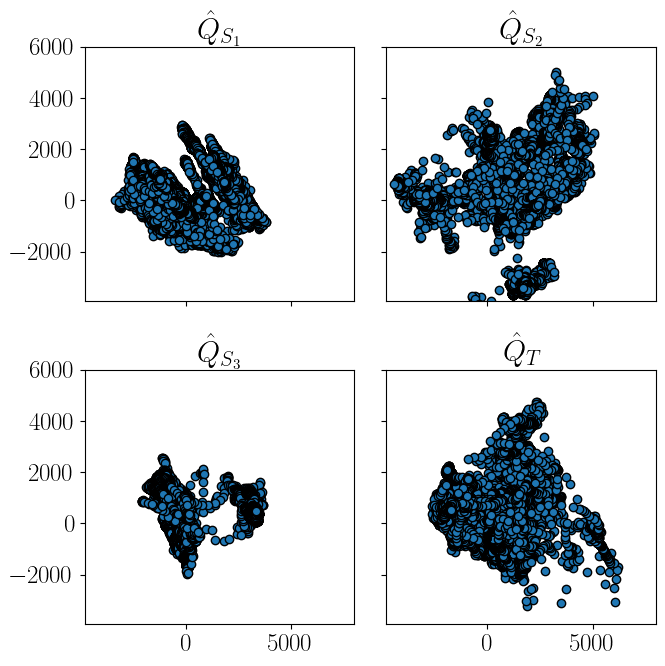

In [87]:
# Concatenate features and labels
all_data = pd.DataFrame(np.concatenate(true_features, axis=0))

# Apply PCA to set the limits to the plot after
pca_all = PCA(n_components=2)
pca_result_all = pca_all.fit_transform(all_data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True, sharey=True)

for i, (Xi, ax) in enumerate(zip(true_features[:-1], axes.flatten()[:-1])):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Xi)
    #ax.scatter(x = pca_result[:, 0], y = pca_result[:, 1])
    ax.scatter(x = pca_result[::2, 0], y = pca_result[::2, 1],edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")
    ax.set_xlim([np.min(pca_result_all[:, 0]) - 5, 8000])
    ax.set_ylim([np.min(pca_result_all[:, 1]) - 5, 6000])

# Plot the last dataset separately
ax = axes.flatten()[-1]
pca_last = pca.fit_transform(true_features[-1]) 
#ax.scatter(pca_last[:, 0], pca_last[:, 1], c=true_labels[-1][:,0], cmap='coolwarm', edgecolor='k')
ax.scatter(pca_last[::2, 0], pca_last[::2, 1],edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

plt.tight_layout()
plt.show()

# continuous data + controled data